In [9]:
import json
import pandas as pd
from typing import Dict
from collections import defaultdict


def get_contributor_stats(data: Dict):
    # Get project name
    project_name = data.get("project_name", "Unknown")

    # Extract relevant commit data
    commit_data = data.get("config_commit_data", [])

    # Dictionary to store contributor stats
    contributors_stats = defaultdict(lambda: {
        "config_commits": 0,
        "non_config_commits": 0,
        "files_changed": defaultdict(int)
    })

    # Process each commit
    for commit in commit_data:
        author = commit["author"].lower()
        is_config_related = commit["is_config_related"]
        changed_files = commit["network_data"].get("config_files", []) if commit["network_data"] else []

        # Count config and non-config commits
        if is_config_related:
            contributors_stats[author]["config_commits"] += 1
        else:
            contributors_stats[author]["non_config_commits"] += 1

        # Count files changed per contributor
        for file in changed_files:
            contributors_stats[author]["files_changed"][file] += 1

    # Create two separate DataFrames: one for commit statistics and one for changed files
    commit_stats_rows = []
    changed_files_rows = []

    for contributor, stats in contributors_stats.items():
        commit_stats_rows.append({
            "Contributor": contributor,
            "Config Commits": stats["config_commits"],
            "Non-Config Commits": stats["non_config_commits"]
        })
        
        for file, count in stats["files_changed"].items():
            changed_files_rows.append({
                "Contributor": contributor,
                "Changed File": file,
                "File Change Count": count
            })

    # Convert to DataFrames
    commit_stats_df = pd.DataFrame(commit_stats_rows)
    changed_files_df = pd.DataFrame(changed_files_rows)
    commit_stats_df = commit_stats_df.sort_values(by="Config Commits", ascending=False)

    latex_table = commit_stats_df.to_latex(index=False, caption=f"Contributors of {project_name}")
    latex_file_path = f"../data/contributors/{project_name}_contributors.tex"
    with open(latex_file_path, "w") as f:
        f.write(latex_table)

    commit_stats_df.to_csv(f"../data/contributors/{project_name}_contributors.csv", index=False)
    changed_files_df.to_csv(f"../data/contributors/{project_name}_contributor_files.csv", index=False)

In [10]:
import json
import glob 

for file_name in glob.glob("../data/analyzed_projects/**"):
    project_name = file_name.split("/")[-1].split(".")[0]

    print(f"Process {project_name}...")

    with open(file_name, "r") as src:
        data = json.load(src)
        get_contributor_stats(data)


Process test-config-repo...
Process poli...
Process yas...
Process pig...
Process music-website...
Process apollo...
Process kkFileView...
Process mall-swarm...
Process piggymetrics...
Process litemall...
Process Spring-Cloud-Platform...
Process mall...


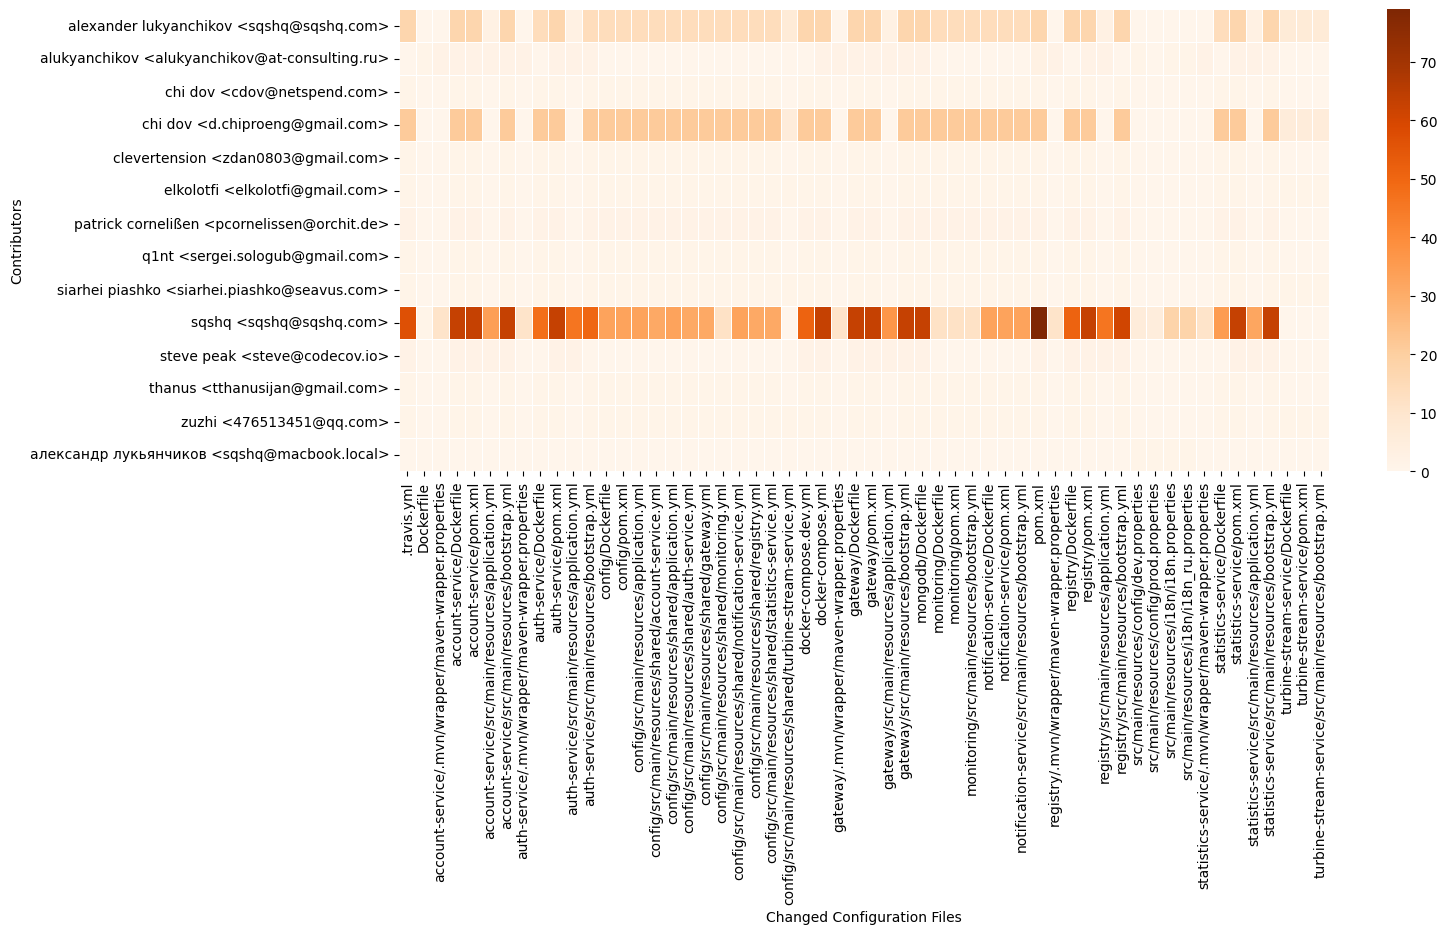

In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

file_name = "../data/contributors/piggymetrics_contributor_files.csv"

df = pd.read_csv(file_name)
df_grouped = df.groupby("Contributor")["File Change Count"].sum().reset_index()

# Remove the filtering step for top contributors
# top_contributors = df_grouped.nlargest(5, "File Change Count")["Contributor"]

# Create a pivot table for heatmap with all contributors
pivot_df = df.pivot(index="Contributor", columns="Changed File", values="File Change Count").fillna(0)

# Plot heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_df, cmap="Oranges", linewidths=0.5, annot=False)
plt.xlabel("Changed Configuration Files")
plt.ylabel("Contributors")
#plt.title("Heatmap of All Contributors and Changed Files")
plt.show()